In [1]:
import os
import osmnx as ox
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pyproj
from pyproj import Proj, transform
from haversine import haversine
from scipy.spatial import distance
from scipy.spatial.distance import euclidean
from datetime import datetime
import heapq
import math
import random
import itertools
from shapely.geometry import Point
from sklearn.neighbors import BallTree
from scipy.spatial import cKDTree
from matplotlib_scalebar.scalebar import ScaleBar
import folium
from folium import plugins
import csv

In [2]:
def load_gtfs_data(gtfs_folder):
    """
    Загружает данные GTFS из папки.

    Параметры:
    - gtfs_folder (строка): путь к папке, содержащей файлы GTFS.

    Возвращает:
    - gtfs_data (словарь): словарь, содержащий данные GTFS. Каждый ключ словаря - это название файла без расширения,
      а каждое значение - это DataFrame Pandas, содержащий данные из соответствующего файла GTFS.
    """
    gtfs_data = {}
    files = ['agency.txt', 'routes.txt', 'trips.txt', 'stops.txt', 'stop_times.txt']
    for file in files:
        gtfs_data[file[:-4]] = pd.read_csv(os.path.join(gtfs_folder, file))
    return gtfs_data


In [3]:
def build_transport_graphs(gtfs_data):
    """
    Строит графы для всех типов транспорта на основе данных GTFS.

    Параметры:
    - gtfs_data (dict): словарь с данными GTFS. Ключи словаря:
        * 'routes': DataFrame Pandas с информацией о маршрутах.
        * 'trips': DataFrame Pandas с информацией о поездках.
        * 'stop_times': DataFrame Pandas с информацией об остановках.

    Возвращает:
    - transport_stops (dict): словарь с информацией об остановках транспорта. Ключи словаря:
        * ID остановки (строка): информация остановки.
    - transport_graphs (dict): словарь с графами транспорта. Ключи словаря:
        * Тип транспорта (строка): граф транспорта.
    """
    transport_stops = {}
    transport_edges = {}
    transport_graphs = {}

    # Проходимся по всем маршрутам
    for _, route in gtfs_data['routes'].iterrows():
        route_id = route['route_id']
        route_type = str(route['route_type'])  # Преобразуем в строку

        # Получаем поездки для текущего маршрута
        trips = gtfs_data['trips'][gtfs_data['trips']['route_id'] == route_id]

        # Создаем словарь для текущего типа транспорта, если его нет
        if route_type not in transport_edges:
            transport_edges[route_type] = []

        # Проходимся по всем поездкам для текущего маршрута
        for _, trip in trips.iterrows():
            trip_id = trip['trip_id']

            # Получаем время остановок для текущей поездки
            stop_times = gtfs_data['stop_times'][gtfs_data['stop_times']['trip_id'] == trip_id]

            # Проходимся по всем остановкам для текущей поездки
            prev_stop = None
            for _, stop_time in stop_times.iterrows():
                stop_id = stop_time['stop_id']

                # Добавляем остановку в словарь, если ее нет
                if stop_id not in transport_stops:
                    transport_stops[stop_id] = {'transport_type': route_type}

                # Добавляем ребро между предыдущей и текущей остановкой
                if prev_stop is not None:
                    transport_edges[route_type].append((prev_stop, stop_id, {'route_type': route_type}))  # Используем route_type как строку

                prev_stop = stop_id

    # Создаем графы для каждого типа транспорта
    for transport_type, edges in transport_edges.items():
        G = nx.Graph()
        G.add_edges_from(edges)
        
        # Добавляем атрибуты utm_x и utm_y для каждой вершины
        for node in G.nodes():
            if 'utm_x' not in G.nodes[node]:
                G.nodes[node]['utm_x'] = 0
            if 'utm_y' not in G.nodes[node]:
                G.nodes[node]['utm_y'] = 0
            if 'layer' not in G.nodes[node]:
                G.nodes[node]['layer'] = transport_type
        
        # Добавляем атрибуты layer и weight для каждого ребра
        for edge in G.edges(data=True):
            if 'layer' not in edge[2]:
                edge[2]['layer'] = edge[2]['route_type']
            if 'weight' not in edge[2]:
                edge[2]['weight'] = 0
        
        transport_graphs[transport_type] = G

    return transport_stops, transport_graphs

In [4]:
def convert_coordinates_to_utm(latitude, longitude):
    """
    Преобразует координаты широты и долготы в систему координат UTM.

    Параметры:
    - latitude (float): Широта в градусах.
    - longitude (float): Долгота в градусах.

    Возвращает:
    - utm_x (float): Координата X в системе UTM.
    - utm_y (float): Координата Y в системе UTM.
    """
    utm_zone = int((longitude + 180) / 6) + 1
    utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')
    utm_x, utm_y = utm_proj(longitude, latitude)
    return utm_x, utm_y


In [5]:
def get_stops_with_coordinates(gtfs_folder):
    """
    Получение информации о всех остановках с их координатами в UTM и принадлежности к типам транспорта.

    Параметры:
    - gtfs_folder (str): Путь к папке с файлами GTFS.

    Возвращает:
    - stops_info (dict): Словарь, содержащий информацию об остановках. Ключи - идентификаторы остановок, значения - словари с информацией о координатах в UTM и типах транспорта.
    - num_stops (int): Количество остановок.
    """
    # Загрузка данных GTFS
    gtfs_data = load_gtfs_data(gtfs_folder)
    
    # Загрузка координат остановок
    stops_df = gtfs_data['stops']
    routes_df = gtfs_data['routes']
    stop_times_df = gtfs_data['stop_times']

    # Создание словаря для хранения остановок с их координатами и типами транспорта
    stops_info = {}

    # Проход по каждой остановке
    for _, stop in stops_df.iterrows():
        note_id = stop['stop_id']  # Изменяем наименование поля на note_id
        stop_lat = stop['stop_lat']
        stop_lon = stop['stop_lon']
        
        # Определение маршрутов, проходящих через эту остановку
        routes = stop_times_df[stop_times_df['stop_id'] == note_id]['trip_id'].unique()
        route_types = routes_df[routes_df['route_id'].isin(gtfs_data['trips'][gtfs_data['trips']['trip_id'].isin(routes)]['route_id'])]['route_type'].unique().tolist()
        
        # Преобразование координат в UTM
        utm_x, utm_y = convert_coordinates_to_utm(stop_lat, stop_lon)
        
        # Преобразование route_type в строку
        route_types_str = ','.join(map(str, route_types))
        
        # Добавление информации об остановке в словарь
        stops_info[note_id] = {'utm_x': utm_x, 'utm_y': utm_y, 'route_type': route_types_str}  # Изменяем stop_id на note_id
        
    return stops_info, len(stops_info)

In [6]:
def update_graph_with_coordinates(graph, stops_with_coordinates):
    """
    Обновляет атрибуты вершин графа координатами UTM на основе данных об остановках.

    Параметры:
    - graph (networkx.Graph): Граф, который нужно обновить.
    - stops_with_coordinates (dict): Словарь с информацией об остановках. Ключи - идентификаторы остановок, значения - словари с координатами UTM.

    Примечание:
    - Если вершина графа имеет идентификатор, совпадающий с ключом из словаря stops_with_coordinates, то атрибуты 'utm_x' и 'utm_y' этой вершины будут обновлены соответствующими значениями координат из словаря stops_with_coordinates.
    """
    for node_id, node_data in graph.nodes(data=True):
        if node_id in stops_with_coordinates:
            coordinates = stops_with_coordinates[node_id]
            node_data['utm_x'] = coordinates['utm_x']
            node_data['utm_y'] = coordinates['utm_y']

In [7]:
def calculate_bounding_box(graphs, padding_ratio=0.1):
    """
    Вычисляет ограничивающий прямоугольник, содержащий все вершины из всех графов.

    Параметры:
    - graphs (dict): Словарь, содержащий графы. Ключи - идентификаторы графов, значения - сами графы.
    - padding_ratio (float): Коэффициент дополнительного отступа от границ графа. По умолчанию 0.1 (10% от размеров графа).

    Возвращает:
    Кортеж из четырех целочисленных значений:
    - bounding_box_min_x (int): Минимальное значение координаты X ограничивающего прямоугольника.
    - bounding_box_max_x (int): Максимальное значение координаты X ограничивающего прямоугольника.
    - bounding_box_min_y (int): Минимальное значение координаты Y ограничивающего прямоугольника.
    - bounding_box_max_y (int): Максимальное значение координаты Y ограничивающего прямоугольника.
    """
    utm_x_values = []
    utm_y_values = []
    
    for graph in graphs.values():
        for node_id, node_data in graph.nodes(data=True):
            utm_x_values.append(node_data['utm_x'])
            utm_y_values.append(node_data['utm_y'])
    
    min_x = min(utm_x_values)
    max_x = max(utm_x_values)
    min_y = min(utm_y_values)
    max_y = max(utm_y_values)
    
    avg_x = (min_x + max_x) / 2
    avg_y = (min_y + max_y) / 2
    
    # Вычисляем размеры ограничивающего прямоугольника
    width = max_x - min_x
    height = max_y - min_y
    
    # Вычисляем дополнительные отступы
    padding_x = width * padding_ratio
    padding_y = height * padding_ratio
    
    # Вычисляем координаты ограничивающего прямоугольника с округлением до целых
    bounding_box_min_x = round(avg_x - padding_x)
    bounding_box_max_x = round(avg_x + padding_x)
    bounding_box_min_y = round(avg_y - padding_y)
    bounding_box_max_y = round(avg_y + padding_y)
    
    return bounding_box_min_x, bounding_box_max_x, bounding_box_min_y, bounding_box_max_y


In [8]:
def crop_graph(graph, min_x, max_x, min_y, max_y):
    """
    Обрезает граф до определенной территории, заданной координатами прямоугольника.
    
    Параметры:
        graph (networkx.Graph): Исходный граф.
        min_x (float): Минимальная координата по оси X.
        max_x (float): Максимальная координата по оси X.
        min_y (float): Минимальная координата по оси Y.
        max_y (float): Максимальная координата по оси Y.
    
    Возвращает:
        networkx.Graph: Обрезанный граф.
    """
    # Создаем копию исходного графа
    cropped_graph = graph.copy()
    
    # Проходимся по вершинам графа и удаляем те, которые не попадают внутрь заданного прямоугольника
    for node in list(graph.nodes()):
        node_data = graph.nodes[node]
        if not (min_x <= node_data['utm_x'] <= max_x and min_y <= node_data['utm_y'] <= max_y):
            cropped_graph.remove_node(node)
    
    # Удаляем ребра, которые связаны с удаленными вершинами
    cropped_graph.remove_edges_from(list(nx.selfloop_edges(cropped_graph)))
    
    # Возвращаем обрезанный граф
    return cropped_graph

In [9]:
def remove_isolated_nodes(graphs):
    """
    Удаляет изолированные вершины из каждого графа в словаре или из одиночного графа.

    Параметры:
    - graphs (dict or networkx.Graph): Словарь, содержащий графы или одиночный граф.
    """
    if isinstance(graphs, nx.Graph):
        graphs = {'graph': graphs}
    
    for graph_name, graph in graphs.items():
        isolated_nodes = list(nx.isolates(graph))
        graph.remove_nodes_from(isolated_nodes)

In [10]:
def load_pedestrian_graph(city_name):
    """
    Загружает пешеходный граф из OSM для указанного города.

    Параметры:
    city_name (str): Название города для загрузки пешеходного графа.

    Возвращает:
    G_walk (networkx.Graph): Пешеходный граф для указанного города (не направленный и без параллельных рёбер)
                             с атрибутами длины рёбер и координатами узлов.
    """
    # Загрузка графа пешеходных дорог из OSM с дополнительной информацией о длине рёбер и координатах узлов
    G_osm = ox.graph_from_place(city_name, network_type='walk')

    # Преобразование графа в формат, подходящий для networkx
    G_walk = nx.Graph(G_osm)

    return G_walk

In [11]:
def convert_coordinates_to_utm_same_zone(latitude, longitude):
    """
    Преобразование координат широты и долготы в UTM с заданной зоной, с учетом текущей зоны.

    Параметры:
    - latitude (float): Широта в градусах.
    - longitude (float): Долгота в градусах.

    Возвращает:
    - utm_x (float): Координата X в UTM.
    - utm_y (float): Координата Y в UTM.
    """
    utm_x, utm_y = convert_coordinates_to_utm(latitude, longitude)
    return utm_x, utm_y


In [12]:
def convert_pedestrian_graph_coordinates_to_utm(G_pedestrian):
    """
    Пересчитывает координаты вершин пешеходного графа в UTM с заданной зоной.

    Параметры:
    - G_pedestrian (networkx.Graph): Пешеходный граф.
    - zone (int): Номер UTM зоны.

    Возвращает:
    - G_pedestrian_utm (networkx.Graph): Пешеходный граф с пересчитанными координатами в UTM.
    """
    G_pedestrian_utm = G_pedestrian.copy()  # Создаем копию пешеходного графа

    # Проходимся по всем вершинам пешеходного графа
    for node, data in G_pedestrian_utm.nodes(data=True):
        # Получаем текущие координаты вершины
        latitude = data['y']
        longitude = data['x']
        # Пересчитываем координаты в UTM
        utm_x, utm_y = convert_coordinates_to_utm_same_zone(latitude, longitude)
        # Обновляем атрибуты вершины с новыми координатами в UTM
        data['utm_x'] = utm_x
        data['utm_y'] = utm_y

    return G_pedestrian_utm

In [13]:
def check_graph_properties(graph):
    result = {}

    # Проверка на изолированные вершины
    isolated_nodes = list(nx.isolates(graph))
    if isolated_nodes:
        result['isolated_nodes'] = isolated_nodes
    else:
        result['isolated_nodes'] = None

    # Проверка на связность
    if nx.is_connected(graph):
        result['connectivity'] = 'Связный'
    else:
        result['connectivity'] = 'Не связный'
        components = list(nx.connected_components(graph))
        result['num_components'] = len(components)
        result['components_size'] = [len(comp) for comp in components]

    return result

In [14]:
def find_nearest_points(comp1, comp2, graph):
    """
    Находит пару вершин с минимальным расстоянием между двумя компонентами связности графа.

    Параметры:
    - comp1 (set): Первая компонента связности.
    - comp2 (set): Вторая компонента связности.
    - graph (networkx.Graph): Граф.

    Возвращает:
    - nearest_points (tuple): Пара вершин с минимальным расстоянием между компонентами связности.
    """
    min_distance = float('inf')
    nearest_points = None
    for node1 in comp1:
        for node2 in comp2:
            distance = np.linalg.norm(np.array([graph.nodes[node1]['utm_x'], graph.nodes[node1]['utm_y']]) - np.array([graph.nodes[node2]['utm_x'], graph.nodes[node2]['utm_y']]))
            if distance < min_distance:
                min_distance = distance
                nearest_points = (node1, node2)
    return nearest_points

def make_graph_connected(graph):
    """
    Превращает граф в связный, добавляя соединительные ребра между компонентами связности.

    Параметры:
    - graph (networkx.Graph): Граф.

    Возвращает:
    - graph (networkx.Graph): Связный граф.
    """
    if nx.is_connected(graph):
        print("Понятно, хорошего дня.")
        return graph

    # Находим компоненты связности
    components = list(nx.connected_components(graph))
    
    # Ищем пары вершин с минимальным расстоянием между компонентами
    min_distance = float('inf')
    selected_nodes = None
    for i, comp1 in enumerate(components):
        for j, comp2 in enumerate(components):
            if i != j:
                nearest_points = find_nearest_points(comp1, comp2, graph)
                distance = np.linalg.norm(np.array([graph.nodes[nearest_points[0]]['utm_x'], graph.nodes[nearest_points[0]]['utm_y']]) - np.array([graph.nodes[nearest_points[1]]['utm_x'], graph.nodes[nearest_points[1]]['utm_y']]))
                if distance < min_distance:
                    min_distance = distance
                    selected_nodes = nearest_points

    # Строим соединительное ребро
    node1, node2 = selected_nodes
    if not graph.has_edge(node1, node2):
        graph.add_edge(node1, node2)
    else:
        print("Ребро между выбранными вершинами уже существует.")

    return graph


In [15]:
def check_graph_properties(graph):
    result = {}

    # Проверка на изолированные вершины
    isolated_nodes = list(nx.isolates(graph))
    if isolated_nodes:
        result['isolated_nodes'] = isolated_nodes
    else:
        result['isolated_nodes'] = None

    # Проверка на связность
    if nx.is_connected(graph):
        result['connectivity'] = 'Связный'
    else:
        result['connectivity'] = 'Не связный'
        components = list(nx.connected_components(graph))
        result['num_components'] = len(components)
        result['components_size'] = [len(comp) for comp in components]

    return result

In [16]:
def add_public_transport_stops_to_pedestrian_graph(cropped_G_walk_utm, cropped_transport_graphs):
    """
    Добавляет вершины для остановок общественного транспорта к пешеходному графу.

    Параметры:
    - cropped_G_walk_utm (networkx.Graph): Обрезанный пешеходный граф с координатами в UTM.
    - cropped_transport_graphs (dict): Словарь обрезанных графов для различных типов транспорта.

    Возвращает:
    - G_walk_with_stops (networkx.Graph): Пешеходный граф с добавленными вершинами для остановок общественного транспорта.
    """
    G_walk_with_stops = cropped_G_walk_utm.copy()  # Создаем копию обрезанного пешеходного графа с координатами в UTM

    # Проходимся по всем обрезанным транспортным графам
    for transport_type, graph in cropped_transport_graphs.items():
        # Проходимся по всем вершинам обрезанного транспортного графа
        for node, node_data in graph.nodes(data=True):
            # Получаем координаты и тип транспорта вершины
            utm_x = node_data['utm_x']
            utm_y = node_data['utm_y']
            layer = node_data['layer']

            # Добавляем вершину для остановки к обрезанному пешеходному графу
            G_walk_with_stops.add_node(node, layer=layer, utm_x=utm_x, utm_y=utm_y)

    return G_walk_with_stops

In [17]:
def find_nearest_node_distances(G_walk_with_stops):
    """
    Находит ближайшие вершины в пешеходном графе к каждой остановке общественного транспорта
    и вычисляет расстояние между ними.

    Параметры:
    - G_walk_with_stops (networkx.Graph): Пешеходный граф с остановками общественного транспорта.

    Возвращает:
    - nearest_node_info (list): Список кортежей, содержащих информацию о ближайших вершинах:
        (stop_id, nearest_node_id, nearest_node_layer, distance).
    """
    # Создаем массив из координат UTM для всех вершин графа, у которых есть атрибуты 'utm_x' и 'utm_y'
    nodes_coords = np.array([[data['utm_x'], data['utm_y'], node, data.get('layer', 'unknown')] for node, data in G_walk_with_stops.nodes(data=True) if 'utm_x' in data and 'utm_y' in data and 'street_count' in data])

    # Строим KD-дерево для быстрого поиска ближайших соседей
    tree = cKDTree(nodes_coords[:, :2])  # Берем только координаты UTM для поиска ближайших соседей

    # Инициализируем список для хранения результатов
    nearest_node_info = []

    # Проходимся по всем остановкам общественного транспорта
    for stop_id, stop_data in G_walk_with_stops.nodes(data=True):
        # Проверяем, является ли текущая вершина остановкой и имеет ли атрибуты 'utm_x' и 'utm_y'
        if 'utm_x' not in stop_data or 'utm_y' not in stop_data or 'layer' not in stop_data:
            continue

        # Получаем координаты UTM текущей остановки
        stop_coords = np.array([stop_data['utm_x'], stop_data['utm_y']])

        # Ищем все ближайшие вершины в массиве координат
        _, nearest_node_indices = tree.query(stop_coords, k=len(nodes_coords))

        # Ищем ближайшую вершину, которая является пешеходной
        for index in nearest_node_indices:
            nearest_node_id = nodes_coords[index, 2]
            if nearest_node_id != stop_id:
                nearest_node_index = index
                break

        # Получаем id и layer ближайшей вершины
        nearest_node_id = int(nodes_coords[nearest_node_index, 2])
        nearest_node_layer = nodes_coords[nearest_node_index, 3]

        # Получаем координаты ближайшей вершины
        nearest_node_coords = nodes_coords[nearest_node_index, :2].astype(float)  # Преобразуем координаты в числовой формат

        # Вычисляем расстояние между остановкой и ближайшей вершиной
        distance = np.linalg.norm(stop_coords.astype(float) - nearest_node_coords)

        # Добавляем информацию о ближайшей вершине в список результатов
        nearest_node_info.append((stop_id, nearest_node_id, nearest_node_layer, distance))

    return nearest_node_info

In [18]:
def add_edges_between_stops_and_nearest_nodes(G_walk_with_stops, nearest_node_info):
    """
    Добавляет ребра между остановками и ближайшими узлами в графе G_walk_with_stops.

    Параметры:
    - G_walk_with_stops (networkx.Graph): Пешеходный граф с добавленными вершинами для остановок общественного транспорта.
    - nearest_node_info (list): Список с информацией о ближайших узлах для остановок.

    Возвращает:
    - G_walk_with_edges (networkx.Graph): Пешеходный граф с добавленными ребрами.
    """
    # Ищем максимальное расстояние
    max_distance = max(distance for _, _, _, distance in nearest_node_info)

    G_walk_with_edges = G_walk_with_stops.copy()  # Создаем копию графа

    # Проходимся по информации о ближайших узлах для остановок
    for stop_id, nearest_node_id, route_type, distance in nearest_node_info:
        # Проверяем, что расстояние меньше максимального расстояния
        if distance < max_distance + 1:
            # Добавляем ребро между остановкой и ближайшим узлом
            G_walk_with_edges.add_edge(stop_id, nearest_node_id, weight=distance)
    
    for u, v, data in G_walk_with_edges.edges(data=True):
        if 'length' in data:
            data['weight'] = data['length']

    return G_walk_with_edges

In [19]:
def assign_edge_costs_with_time(cropped_transport_graphs, gtfs_data):
    """
    Назначает стоимость для ребер на основе времени между остановками.

    Параметры:
    - cropped_transport_graphs (dict): Словарь обрезанных транспортных графов.
    - gtfs_data (dict): Данные GTFS.

    Возвращает:
    - None
    """
    num_edges_with_costs = 0  # Переменная для подсчета количества ребер с назначенными весами
    for transport_type, graph in cropped_transport_graphs.items():
        # Получаем данные о времени для всех остановок
        stop_times = gtfs_data['stop_times']
        # Проходимся по всем ребрам графа
        for u, v, attr in graph.edges(data=True):
            # Получаем идентификаторы остановок
            stop_u = u
            stop_v = v
            # Получаем данные о времени для остановок
            stop_times_u = stop_times[stop_times['stop_id'] == stop_u]
            stop_times_v = stop_times[stop_times['stop_id'] == stop_v]
            # Получаем время отправления из предыдущей остановки и прибытия на следующую остановку
            departure_time_u = stop_times_u.iloc[0]['departure_time']
            arrival_time_v = stop_times_v.iloc[0]['arrival_time']
            # Преобразуем строки времени в объекты datetime для вычисления разницы времени
            departure_time_u = datetime.strptime(departure_time_u, '%H:%M:%S')
            arrival_time_v = datetime.strptime(arrival_time_v, '%H:%M:%S')
            # Вычисляем разницу во времени между остановками и берем ее абсолютное значение
            duration = abs(arrival_time_v - departure_time_u)
            # Присваиваем стоимость ребру по времени (в секундах)
            graph[u][v]['weight'] = duration.total_seconds()
            num_edges_with_costs += 1  # Увеличиваем счетчик ребер с назначенными весами

In [20]:
def distances_from_source_to_all_stops_dijkstra(graph):
    """
    Находит кратчайшие расстояния от случайно выбранной стартовой остановки до всех остальных остановок в графе
    с использованием алгоритма Дейкстры.

    Параметры:
    - graph (networkx.Graph): Граф, представляющий собой сеть общественного транспорта, в котором
      вершины представляют остановки, а ребра - маршруты между ними.

    Возвращает:
    - distances (dict): Словарь, где ключи - идентификаторы остановок, а значения - кратчайшие расстояния
      от стартовой остановки до каждой остановки. Если расстояние до остановки не найдено, значение будет None.
    - num_lines_dijkstra (int): Количество строк, выведенных в процессе работы алгоритма.
    """
    distances = {}  # Словарь для хранения расстояний

    # Получаем все остановки общественного транспорта
    public_transport_stops = [node for node, attr in graph.nodes(data=True) if 'layer' in attr]

    # Выбираем случайную стартовую остановку
    source_stop = random.choice(public_transport_stops)

    # Алгоритм Дейкстры
    pq = [(0, source_stop)]  # Приоритетная очередь для обработки вершин
    num_lines_dijkstra = 0  # Счетчик строк
    while pq:
        dist, node = heapq.heappop(pq)
        if node in distances:
            continue
        distances[node] = dist
        for neighbor, attrs in graph[node].items():
            if 'weight' in attrs:
                new_dist = dist + attrs['weight']
                if neighbor != source_stop:  # Пропускаем вычисления для стартовой остановки
                    heapq.heappush(pq, (new_dist, neighbor))
                    # Выводим расстояние, если соседняя вершина является остановкой общественного транспорта
                    if neighbor in public_transport_stops:
                        num_lines_dijkstra += 1

    # Проверяем, найдены ли расстояния до всех остановок
    for stop in public_transport_stops:
        if stop not in distances:
            distances[stop] = None

    return distances, num_lines_dijkstra

In [21]:
def all_distances_between_stops(graph):
    """
    Находит расстояния между всеми парами остановок в графе с использованием алгоритма Дейкстры.

    Параметры:
    - graph (networkx.Graph): Граф, представляющий собой сеть общественного транспорта, в котором вершины представляют остановки, а ребра - маршруты между ними.

    Возвращает:
    - unique_distances (dict): Словарь, в котором ключами являются кортежи (source_stop, target_stop) остановок, а значениями - соответствующие расстояния между ними. Если между остановками нет пути, их расстояние будет равно None.
    - num_lines (int): Количество выведенных строк с информацией о найденных расстояниях между остановками.
    """
    # Получаем все остановки общественного транспорта
    public_transport_stops = [node for node, attr in graph.nodes(data=True) if 'layer' in attr]

    # Словарь для хранения уникальных расстояний
    unique_distances = {}

    # Счетчик строк
    num_lines = 0

    # Проходимся по каждой остановке
    for i in range(len(public_transport_stops)):
        source_stop = public_transport_stops[i]

        # Алгоритм Дейкстры
        pq = [(0, source_stop)]  # Приоритетная очередь для обработки вершин
        processed_stops = set()  # Множество для отслеживания обработанных остановок

        while pq:
            dist, node = heapq.heappop(pq)

            # Проверяем, обработана ли уже текущая остановка
            if node in processed_stops:
                continue

            # Добавляем найденное расстояние в словарь
            if node != source_stop and (source_stop, node) not in unique_distances:
                unique_distances[(source_stop, node)] = dist

            # Добавляем текущую остановку в множество обработанных
            processed_stops.add(node)

            # Проходим по соседям текущей остановки
            for neighbor, attrs in graph[node].items():
                if 'weight' in attrs:
                    new_dist = dist + attrs['weight']
                    heapq.heappush(pq, (new_dist, neighbor))      

    return unique_distances


In [22]:
def create_transfer_graph(distances, graphs):
    """
    Создает граф G_transfer на основе расстояний между остановками и графов общественного транспорта.

    Параметры:
    - distances: Словарь с расстояниями между остановками.
    - graphs: Словарь с графами общественного транспорта.

    Возвращает:
    - G_transfer: Граф с информацией о пересадочных путях между остановками.
    """
    # Создаем пустой граф
    G_transfer = nx.Graph()

    # Добавляем вершины (остановки) из всех графов
    for graph in graphs.values():
        for node, node_attrs in graph.nodes(data=True):
            if 'layer' in node_attrs:
                G_transfer.add_node(node, layer='transfer', utm_x=node_attrs['utm_x'], utm_y=node_attrs['utm_y'])

    # Добавляем ребра на основе расстояний
    for (source_stop, target_stop), distance in distances.items():
        if source_stop in G_transfer.nodes() and target_stop in G_transfer.nodes():
            G_transfer.add_edge(source_stop, target_stop, layer='transfer', weight=distance)

    return G_transfer

In [23]:
def convert_distance_to_time(G_transfer, walking_speed_kmh=5):
    """
    Конвертирует атрибут weight в графе G_transfer из метров во время в секундах.

    Параметры:
    - G_transfer (networkx.Graph): Граф G_transfer с атрибутом weight в метрах.
    - walking_speed_kmh (float): Скорость ходьбы в км/ч. По умолчанию 5 км/ч.

    Возвращает:
    - G_transfer (networkx.Graph): Граф G_transfer с атрибутом weight в секундах.
    """
    # Конвертируем скорость ходьбы из км/ч в м/c
    walking_speed_ms = walking_speed_kmh * 1000 / 3600

    # Проходим по каждому ребру графа G_transfer
    for u, v, attr in G_transfer.edges(data=True):
        # Получаем расстояние между остановками (в метрах)
        distance_m = attr['weight']
        # Вычисляем время (в секундах), необходимое для преодоления расстояния
        time_sec = distance_m / walking_speed_ms
        # Обновляем атрибут weight в секундах
        attr['weight'] = time_sec

    return G_transfer

In [24]:
def remove_long_edges_inplace(G_transfer_with_time, max_time=1800):
    """
    Удаляет ребра из графа G_transfer, у которых вес (время) больше max_time.

    Параметры:
    - G_transfer (networkx.Graph): Граф G_transfer с атрибутом weight в секундах.
    - max_time (float): Максимальное время в секундах. По умолчанию 6000 секунд.

    Ничего не возвращает, изменяет граф G_transfer внутри функции.
    """
    # Проходим по каждому ребру графа G_transfer в обратном порядке
    for u, v, attr in list(G_transfer_with_time.edges(data=True)):
        # Проверяем, если вес (время) ребра больше max_time
        if attr['weight'] > max_time:
            # Удаляем ребро из графа
            G_transfer_with_time.remove_edge(u, v)

In [25]:
def extract_vertices_from_graphs(cropped_transport_graphs, G_transfer):
    """
    Извлекает вершины из транспортных графов и графа передачи, сохраняя атрибуты каждой вершины.

    Параметры:
    - cropped_transport_graphs (dict): Словарь обрезанных транспортных графов.
    - G_transfer (networkx.Graph): Граф передачи.

    Возвращает:
    - all_vertices (list): Список словарей, где каждый словарь представляет вершину. Каждая вершина имеет следующие атрибуты:
        - 'stop_id': Идентификатор остановки.
        - 'utm_x': Координата X в системе UTM.
        - 'utm_y': Координата Y в системе UTM.
        - 'layer': Тип слоя (например, тип транспорта).
    """
    all_vertices = []  # Список для хранения вершин

    # Проходим по каждому транспортному графу в словаре cropped_transport_graphs
    for transport_type, graph in cropped_transport_graphs.items():
        # Проходим по каждой остановке в графе
        for node, node_attrs in graph.nodes(data=True):
            # Создаем словарь для хранения атрибутов вершины
            vertex = {
                'stop_id': node,  # Используем node в качестве note_id
                'utm_x': node_attrs['utm_x'],
                'utm_y': node_attrs['utm_y'],
                'layer': node_attrs['layer']  # Используем атрибут 'layer'
            }
            # Добавляем вершину в массив вершин
            all_vertices.append(vertex)

    # Проходим по каждой вершине в графе G_transfer
    for node, attrs in G_transfer.nodes(data=True):
        # Получаем атрибуты вершины
        stop_id = node
        utm_x = attrs['utm_x']
        utm_y = attrs['utm_y']
        layer = attrs['layer']
        
        # Записываем атрибуты вершины в массив вершин all_vertices
        all_vertices.append({'stop_id': stop_id, 'utm_x': utm_x, 'utm_y': utm_y, 'layer': layer})

    return all_vertices

In [26]:
def count_unique_layer_values(vertices):
    """
    Подсчитывает количество уникальных значений атрибута "layer" среди вершин.

    Параметры:
    - vertices (list): Список вершин, каждая вершина представлена словарем с атрибутами.

    Возвращает:
    - unique_values_count (int): Количество уникальных значений атрибута "layer".
    """
    unique_values_count = 0  # Инициализируем счетчик уникальных значений
    encountered_values = set()  # Создаем множество для отслеживания уже встреченных значений
    for vertex in vertices:
        layer = vertex['layer']  # Получаем значение атрибута "layer"
        if layer != 'transfer' and layer not in encountered_values:  # Проверяем, отличается ли значение от "transfer" и не встречалось ли ранее
            unique_values_count += 1  # Увеличиваем счетчик
            encountered_values.add(layer)  # Добавляем значение в множество встреченных значений
    return unique_values_count  # Возвращаем количество уникальных значений


In [27]:
def create_bipartite_graphs(unique_values_count):
    """
    Создает пустые двудольные графы.

    Параметры:
    - unique_values_count (int): Количество двудольных графов, которые нужно создать.

    Возвращает:
    - bipartite_graphs (dict): Словарь, содержащий созданные двудольные графы.
    """
    bipartite_graphs = {}
    for i in range(1, unique_values_count + 1):
        graph_name = f'B_{i}'
        bipartite_graphs[graph_name] = nx.Graph()
    return bipartite_graphs


In [28]:
def fill_bipartite_graphs(bipartite_graphs, all_vertices):
    """
    Заполняет двудольные графы вершинами из списка всех вершин.

    Параметры:
    - bipartite_graphs (dict): Словарь двудольных графов.
    - all_vertices (list): Список вершин, каждая вершина представлена словарем с атрибутами.

    Возвращает:
    - bipartite_graphs (dict): Обновленный словарь двудольных графов.
    """
    for graph_name, graph in bipartite_graphs.items():
        # Находим граф для заполнения
        if graph_name == 'B_1':
            transfer_vertices = [((vertex['stop_id'], vertex['layer']), vertex) for vertex in all_vertices if vertex['layer'] == 'transfer']
            graph.add_nodes_from(transfer_vertices, bipartite=0)
            layer_3_vertices = [((vertex['stop_id'], vertex['layer']), vertex) for vertex in all_vertices if vertex['layer'] == '3']
            graph.add_nodes_from(layer_3_vertices, bipartite=1)
        elif graph_name == 'B_2':
            transfer_vertices = [((vertex['stop_id'], vertex['layer']), vertex) for vertex in all_vertices if vertex['layer'] == 'transfer']
            graph.add_nodes_from(transfer_vertices, bipartite=0)
            layer_0_vertices = [((vertex['stop_id'], vertex['layer']), vertex) for vertex in all_vertices if vertex['layer'] == '0']
            graph.add_nodes_from(layer_0_vertices, bipartite=1)
    return bipartite_graphs


In [29]:
def create_edges(bipartite_graphs, all_vertices):
    """
    Строит ребра в каждом из двудольных графов на основе координат вершин.

    Параметры:
    - bipartite_graphs (dict): Словарь с созданными двудольными графами.
    - all_vertices (list): Список всех вершин.

    Возвращает:
    - edges_count (dict): Словарь с количеством ребер для каждого графа.
    - edges_list (dict): Словарь со списком ребер и их атрибутами для каждого графа.
    """
    edges_count = {}
    edges_list = {}

    for graph_name, graph in bipartite_graphs.items():
        edges = []
        count = 0
        for vertex in graph.nodes(data=True):
            if vertex[1]['bipartite'] == 1:
                for other_vertex in all_vertices:
                    if other_vertex['utm_x'] == vertex[1]['utm_x'] and other_vertex['utm_y'] == vertex[1]['utm_y']:
                        edge_attrs = {
                            'id_1': other_vertex['stop_id'],
                            'id_2': other_vertex['stop_id'],  # Значение id_2 теперь равно id_1
                            'layer': 'dismount',
                            'weight': 0
                        }
                        edges.append((other_vertex['stop_id'], vertex[0], edge_attrs))
                        count += 1
        edges_count[graph_name] = count
        edges_list[graph_name] = edges

    return edges_count, edges_list

In [30]:
def remove_duplicate_edges(edges_list):
    """
    Удаляет дублирующиеся ребра из списка ребер.

    Параметры:
    - edges_list (list): Список ребер с их атрибутами.

    Возвращает:
    - unique_edges_list (list): Список уникальных ребер.
    """
    unique_edges_set = set()
    for edge in edges_list:
        # Преобразуем каждое ребро в хешируемый кортеж
        edge_tuple = (edge[0], edge[1], tuple(edge[2].items()))
        unique_edges_set.add(edge_tuple)
    # Преобразуем обратно в список
    unique_edges_list = [(*edge[:2], dict(edge[2])) for edge in unique_edges_set]
    return unique_edges_list

In [31]:
def extract_edges_data(cropped_transport_graphs):
    """
    Извлекает информацию о ребрах из словаря транспортных графов.

    Параметры:
    - cropped_transport_graphs (dict): Словарь транспортных графов.

    Возвращает:
    - all_edges (list): Список словарей с информацией о ребрах.
    """
    all_edges = []

    # Проходимся по всем графам
    for transport_type, graph in cropped_transport_graphs.items():
        # Проходимся по всем ребрам в текущем графе
        for edge in graph.edges(data=True):
            id_1, id_2 = edge[:2]  # Получаем вершины ребра
            attributes = edge[2]  # Получаем атрибуты ребра
            layer = attributes.get('layer', None)  # Получаем значение атрибута 'layer'
            weight = attributes.get('weight', None)  # Получаем значение атрибута 'weight'

            # Добавляем информацию о ребре в массив all_edges в виде словаря
            all_edges.append({'id_1': id_1, 'id_2': id_2, 'layer': layer, 'weight': weight})

    return all_edges

In [32]:
def add_edges_from_edges_list(edges_list, all_edges):
    """
    Добавляет ребра из списка ребер в массив all_edges.

    Параметры:
    - edges_list (list): Список ребер с их атрибутами.
    - all_edges (list): Массив, в который будут добавлены ребра.

    Возвращает:
    - None
    """
    for edge in edges_list:
        id_1, id_2, attributes = edge  # Распаковываем ребро
        layer = attributes.get('layer', None) if isinstance(attributes, dict) else None
        weight = attributes.get('weight', None) if isinstance(attributes, dict) else None
        
        # Присваиваем id_2 значение id_1, если id_2 задано в edges_list
        if id_2 is not None:
            id_2 = id_1
        
        # Добавляем информацию о ребре в массив all_edges в виде словаря
        all_edges.append({'id_1': id_1, 'id_2': id_2, 'layer': layer, 'weight': weight})


In [33]:
def add_edges_from_transfer_graph(transfer_graph, all_edges):
    """
    Добавляет ребра из графа transfer_graph в массив all_edges.

    Параметры:
    - transfer_graph (networkx.Graph): Граф с ребрами для добавления.
    - all_edges (list): Массив, в который будут добавлены ребра.

    Возвращает:
    - None
    """
    for id_1, id_2, attributes in transfer_graph.edges(data=True):
        layer = attributes.get('layer', None)
        weight = attributes.get('weight', None)
        
        # Добавляем информацию о ребре в массив all_edges в виде словаря
        all_edges.append({'id_1': id_1, 'id_2': id_2, 'layer': layer, 'weight': weight})

In [34]:
def add_vertices_to_graph(graph, vertices):
    """
    Добавляет вершины из списка вершин в граф, обеспечивая уникальность вершин по комбинации (stop_id, layer).

    Параметры:
    - graph (networkx.Graph): Граф, в который будут добавлены вершины.
    - vertices (list): Список словарей с информацией о вершинах.

    Возвращает:
    - None
    """
    # Создаем словарь для хранения вершин по уникальной комбинации (stop_id, layer)
    unique_vertices = {}
    
    # Заполняем словарь уникальными вершинами
    for vertex in vertices:
        stop_id = vertex['stop_id']
        utm_x = vertex['utm_x']
        utm_y = vertex['utm_y']
        layer = vertex['layer']
        key = (stop_id, layer)
        
        # Проверяем, есть ли уже такая вершина в словаре
        if key not in unique_vertices:
            unique_vertices[key] = {'stop_id': stop_id, 'utm_x': utm_x, 'utm_y': utm_y, 'layer': layer}
    
    # Добавляем вершины из словаря в граф
    for key, attributes in unique_vertices.items():
        graph.add_node(key, **attributes)


In [35]:
def add_edges_to_graph(graph, edges):
    """
    Добавляет ребра из списка ребер в граф.

    Параметры:
    - graph (networkx.Graph): Граф, в который будут добавлены ребра.
    - edges (list): Список словарей с информацией о ребрах.

    Возвращает:
    - None
    """
    for edge in edges:
        id_1 = edge['id_1']
        id_2 = edge['id_2']
        layer = edge['layer']
        weight = edge['weight']
        
        if layer in ['3', '0', 'transfer']:
            # Находим вершины с соответствующими id и layer
            vertices_with_id_1 = [v for v in graph.nodes(data=True) if v[0][0] == id_1 and v[0][1] == layer]
            vertices_with_id_2 = [v for v in graph.nodes(data=True) if v[0][0] == id_2 and v[0][1] == layer]
            
            # Если найдены соответствующие вершины, добавляем ребро
            if vertices_with_id_1 and vertices_with_id_2:
                graph.add_edge(vertices_with_id_1[0][0], vertices_with_id_2[0][0], layer=layer, weight=weight)

In [36]:
def add_dismount_edges_to_graph(graph, edges):
    """
    Добавляет ребра спешивания из списка ребер в граф.

    Параметры:
    - graph (networkx.Graph): Граф, в который будут добавлены ребра.
    - edges (list): Список словарей с информацией о ребрах.

    Возвращает:
    - None
    """
    for edge in edges:
        if edge['layer'] == 'dismount':
            id_1 = edge['id_1']
            id_2 = edge['id_2']
            weight = edge['weight']
            
            # Находим вершины с stop_id равным id_1
            vertices_with_id_1 = [v for v in graph.nodes(data=True) if v[0][0] == id_1]
            
            # Должно быть только две такие вершины
            if len(vertices_with_id_1) == 2:
                vertex_1 = vertices_with_id_1[0][0]
                vertex_2 = vertices_with_id_1[1][0]
                
                # Добавляем ребро между найденными вершинами
                graph.add_edge(vertex_1, vertex_2, layer='dismount', weight=weight)


In [37]:
def create_multilayer_network(gtfs_folder, city_name):
    """
    Создает многослойную сеть на основе данных GTFS и пешеходного графа из OSM для указанного города.

    Параметры:
    - gtfs_folder (строка): Путь к папке, содержащей файлы GTFS.
    - city_name (строка): Название города.

    Возвращает:
    - G_multilayer (networkx.MultiGraph): Многослойный граф, содержащий пешеходные дороги и транспортные маршруты.
    """
    # Загрузка данных GTFS
    gtfs_data = load_gtfs_data(gtfs_folder)

    # Строим транспортные графы
    transport_stops, transport_graphs = build_transport_graphs(gtfs_data)

    stops_with_coordinates, num_stops = get_stops_with_coordinates(gtfs_folder)

    for transport_type, graph in transport_graphs.items():
        update_graph_with_coordinates(graph, stops_with_coordinates)

    # Пример использования:
    min_x, max_x, min_y, max_y = calculate_bounding_box(transport_graphs)

    # Обрезаем транспортные графы
    cropped_transport_graphs = {}
    for transport_type, graph in transport_graphs.items():
        cropped_graph = crop_graph(graph, min_x, max_x, min_y, max_y)
        cropped_transport_graphs[transport_type] = cropped_graph
    
    # Удаляем изолированные вершины из графов в cropped_transport_graphs
    remove_isolated_nodes(cropped_transport_graphs)

    # Загрузка пешеходного графа из OSM
    G_walk = load_pedestrian_graph(city_name)

    # Пересчитываем координаты вершин в UTM
    G_walk_utm = convert_pedestrian_graph_coordinates_to_utm(G_walk)

    # Обрезаем граф
    cropped_G_walk_utm = crop_graph(G_walk_utm, min_x, max_x, min_y, max_y)

    # Удаляем изолированные вершины из графа cropped_G_walk_utm
    remove_isolated_nodes(cropped_G_walk_utm)

    cropped_G_walk_utm = make_graph_connected(cropped_G_walk_utm)

    # Пример использования функции
    G_walk_with_stops = add_public_transport_stops_to_pedestrian_graph(cropped_G_walk_utm, cropped_transport_graphs)

    # Получаем информацию о ближайших вершинах для остановок общественного транспорта
    nearest_node_info = find_nearest_node_distances(G_walk_with_stops)

    # Пример использования функции
    G_walk_with_edges = add_edges_between_stops_and_nearest_nodes(G_walk_with_stops, nearest_node_info)

    # Применяем функцию для назначения весов ребрам на основе времени между остановками
    assign_edge_costs_with_time(cropped_transport_graphs, gtfs_data)

    distances_dijkstra, num_lines_dijkstra = distances_from_source_to_all_stops_dijkstra(G_walk_with_edges)

    # Вызываем функцию для графа G_walk_with_edges
    unique_distances = all_distances_between_stops(G_walk_with_edges)

    # Создаем граф G_transfer
    G_transfer = create_transfer_graph(unique_distances, cropped_transport_graphs)

    # Применяем функцию для конвертации атрибута weight в графе G_transfer
    G_transfer_with_time = convert_distance_to_time(G_transfer)

    # Применяем функцию для удаления ребер с весом более N секунд
    remove_long_edges_inplace(G_transfer_with_time)

    all_vertices = extract_vertices_from_graphs(cropped_transport_graphs, G_transfer)

    # Вызываем функцию для подсчета уникальных значений атрибута "layer"
    unique_values_count = count_unique_layer_values(all_vertices)

    # Создаем двудольные графы
    bipartite_graphs = create_bipartite_graphs(unique_values_count)

    # Применяем функцию к пустым графам
    filled_bipartite_graphs = fill_bipartite_graphs(bipartite_graphs, all_vertices)

    # Строим ребра в каждом из двудольных графов
    edges_count, edges_list = create_edges(bipartite_graphs, all_vertices)

    # Применяем функцию к списку ребер каждого графа и считаем количество ребер
    edges_count = {}
    for graph_name, edges in edges_list.items():
        unique_edges = remove_duplicate_edges(edges)
        edges_list[graph_name] = unique_edges
        edges_count[graph_name] = len(unique_edges)

    all_edges = extract_edges_data(cropped_transport_graphs)

    # Применяем функцию к списку ребер каждого графа и считаем количество ребер
    edges_count = {}
    for graph_name, edges in edges_list.items():
        add_edges_from_edges_list(edges, all_edges)

    # Добавляем ребра из графа G_transfer_with_time в массив all_edges
    add_edges_from_transfer_graph(G_transfer_with_time, all_edges)

    # Создаем пустой граф G_multilayer
    G_multilayer = nx.Graph()

    # Добавляем все вершины из массива all_vertices в граф G_multilayer
    add_vertices_to_graph(G_multilayer, all_vertices)

    # Добавляем ребра в граф G_multilayer
    add_edges_to_graph(G_multilayer, all_edges)

    # Добавляем рёбра с атрибутом 'dismount' в граф
    add_dismount_edges_to_graph(G_multilayer, all_edges)

    return G_multilayer

In [38]:
gtfs_folder = 'D:/MSU/MLN/GTFS/GTFS_PM1623357844_Казань'
city_name = "Казань"
G_multilayer = create_multilayer_network(gtfs_folder, city_name)

# Проверяем определение G_multilayer
print(G_multilayer) 

Graph with 498 nodes and 9913 edges


In [39]:
# Создание словаря для подсчета вершин по слоям
layer_counts = {}

# Перебор всех вершин в графе
for node, data in G_multilayer.nodes(data=True):
    # Извлечение значения 'layer' для текущей вершины
    layer = data['layer']
    
    # Обновление счетчика для текущего слоя
    if layer in layer_counts:
        layer_counts[layer] += 1
    else:
        layer_counts[layer] = 1

# Вывод результата
print("Слой : Количество вершин")
for layer, count in layer_counts.items():
    print(f"{layer} : {count}")


Слой : Количество вершин
3 : 202
0 : 47
transfer : 249


In [40]:
#0 Все кратчайшие пути
def find_all_shortest_paths(G_multilayer):
    """
    Находит все кратчайшие пути между всеми парами вершин в многослойном графе.

    Параметры:
    - G_multilayer (networkx.Graph): Многослойный граф.

    Возвращает:
    - all_shortest_paths (dict): Словарь, содержащий кратчайшие пути для каждой пары вершин.
    """
    # Создаем пустой словарь для хранения кратчайших путей для каждой пары вершин
    all_shortest_paths = {}
    
    # Проходим по каждой паре вершин в графе
    for source in G_multilayer.nodes():
        for target in G_multilayer.nodes():
            if source != target:
                # Находим кратчайший путь между source и target в многослойной сети
                shortest_path = nx.shortest_path(G_multilayer, source, target)
                
                # Добавляем кратчайший путь в словарь для текущей пары вершин
                all_shortest_paths[(source, target)] = shortest_path
    
    return all_shortest_paths
all_shortest_paths = find_all_shortest_paths(G_multilayer)

In [41]:
#1 Центральность по кросс-промежуточности (относительно слоев)
def compute_cross_layer_betweenness_centrality(G_multilayer, all_shortest_paths, node_id, vertex_layer, layer_1, layer_2):
    node_layer = G_multilayer.nodes[node_id]['layer']
    cross_layer_betweenness = 0

    for path in all_shortest_paths.values():
        if node_id in path:
            layers = [G_multilayer.nodes[node]['layer'] for node in path]
            if node_layer in layers and layer_1 in layers and layer_2 in layers:
                cross_layer_betweenness += 1

    return cross_layer_betweenness

def cross_layer_betweenness_centrality(G_multilayer, all_shortest_paths, vertex_id, vertex_layer, layer_1, layer_2):
    """
    Вычисляет, визуализирует и сохраняет центральность пересечения слоев для указанной вершины в графе в CSV файл.

    Параметры:
    - G_multilayer (networkx.Graph): Граф.
    - all_shortest_paths (dict): Словарь с кратчайшими путями для каждой пары вершин.
    - vertex_id (str): Идентификатор вершины.
    - vertex_layer (str): Слой вершины.
    - layer_1 (str): Первый слой, относительно которого вычисляется показатель центральности.
    - layer_2 (str): Второй слой, относительно которого вычисляется показатель центральности.
    - output_file (str): Путь к выходному файлу.

    Возвращает:
    - cross_layer_betweenness (dict): Словарь, содержащий значение центральности пересечения слоев для указанной вершины.
    """
    # Функция вычисления центральности пересечения слоев
    def compute_cross_layer_betweenness_centrality(G_multilayer, all_shortest_paths, vertex_id, layer_1, layer_2):
        cross_layer_betweenness = 0

        for path in all_shortest_paths.values():
            if vertex_id in path:
                layers = [G_multilayer.nodes[node]['layer'] for node in path]
                if vertex_layer in layers and layer_1 in layers and layer_2 in layers:
                    cross_layer_betweenness += 1

        return cross_layer_betweenness

    # Вычисление центральности
    comp_cross_layer_betweenness = compute_cross_layer_betweenness_centrality(G_multilayer, all_shortest_paths, vertex_id, layer_1, layer_2)

    return {vertex_id: comp_cross_layer_betweenness}

def compute_cross_layer_betweenness_for_all_vertices(G_multilayer, all_shortest_paths, layer_1, layer_2):
    """
    Вычисляет центральность пересечения слоев для всех вершин в графе, кроме вершин с заданными слоями.

    Параметры:
    - G_multilayer (networkx.Graph): Граф.
    - all_shortest_paths (dict): Словарь с кратчайшими путями для каждой пары вершин.
    - layer_1 (str): Первый слой, относительно которого вычисляется показатель центральности.
    - layer_2 (str): Второй слой, относительно которого вычисляется показатель центральности.

    Возвращает:
    - cross_layer_betweenness (dict): Словарь, содержащий значение центральности пересечения слоев для каждой вершины.
    """
    cross_layer_betweenness = {}

    for node_id in G_multilayer.nodes():
        vertex_layer = G_multilayer.nodes[node_id]['layer']
        if vertex_layer != layer_1 and vertex_layer != layer_2:
            cross_layer_betweenness[node_id] = compute_cross_layer_betweenness_centrality(G_multilayer, all_shortest_paths, node_id, vertex_layer, layer_1, layer_2)

    return cross_layer_betweenness

def save_cross_layer_betweenness_to_csv_with_coordinates(G_multilayer, cross_layer_betweenness, output_file):
    """
    Сохраняет центральность пересечения слоев для каждой вершины в графе в CSV файл вместе с координатами вершин.

    Параметры:
    - G_multilayer (networkx.Graph): Граф.
    - cross_layer_betweenness (dict): Словарь с значениями центральности пересечения слоев для каждой вершины.
    - output_file (str): Путь к выходному файлу для сохранения результатов в CSV.
    """
    data = []

    for node_id, centrality in cross_layer_betweenness.items():
        layer = G_multilayer.nodes[node_id]['layer']
        utm_x = G_multilayer.nodes[node_id]['utm_x']
        utm_y = G_multilayer.nodes[node_id]['utm_y']
        data.append({'Node': node_id, 'Layer': layer, 'Cross_layer_betweenness': centrality, 'UTM_X': utm_x, 'UTM_Y': utm_y})

    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)

def cross_layer_betweenness_centrality(G_multilayer, all_shortest_paths, layer_1, layer_2, output_file):

    """
    Вычисляет, визуализирует и сохраняет центральность пересечения слоев для всех вершин в графе в CSV файл.

    Параметры:
    - G_multilayer (networkx.Graph): Граф.
    - all_shortest_paths (dict): Словарь с кратчайшими путями для каждой пары вершин.
    - layer_1 (str): Первый слой, относительно которого вычисляется показатель центральности.
    - layer_2 (str): Второй слой, относительно которого вычисляется показатель центральности.
    - output_file (str): Путь к выходному файлу.

    Возвращает:
    - cross_layer_betweenness (dict): Словарь, содержащий значение центральности пересечения слоев для каждой вершины.
    """
    # Вычисление центральности для всех вершин
    cross_layer_betweenness_all_vertices = compute_cross_layer_betweenness_for_all_vertices(G_multilayer, all_shortest_paths, layer_1, layer_2)

    # Сохранение центральности в CSV
    save_cross_layer_betweenness_to_csv_with_coordinates(G_multilayer, cross_layer_betweenness_all_vertices, output_file)

    return cross_layer_betweenness_all_vertices

layer_1 = "0"  # Первый слой
layer_2 = "3"  # Второй слой
output_file = "cross_betweenness_centrality.csv"  # Путь к выходному файлу
# Вызов функции
cross_layer_betweenness_centrality(G_multilayer, all_shortest_paths, layer_1, layer_2, output_file)

{(35718, 'transfer'): 809,
 (36261, 'transfer'): 483,
 (36262, 'transfer'): 524,
 (36263, 'transfer'): 356,
 (36264, 'transfer'): 239,
 (36265, 'transfer'): 284,
 (36266, 'transfer'): 328,
 (36267, 'transfer'): 144,
 (36268, 'transfer'): 74,
 (36269, 'transfer'): 90,
 (36270, 'transfer'): 98,
 (36271, 'transfer'): 94,
 (35381, 'transfer'): 184,
 (35382, 'transfer'): 142,
 (35797, 'transfer'): 314,
 (35642, 'transfer'): 210,
 (35954, 'transfer'): 86,
 (35955, 'transfer'): 98,
 (35569, 'transfer'): 224,
 (35570, 'transfer'): 120,
 (35572, 'transfer'): 132,
 (35537, 'transfer'): 132,
 (35764, 'transfer'): 216,
 (35765, 'transfer'): 228,
 (35766, 'transfer'): 114,
 (36272, 'transfer'): 98,
 (36273, 'transfer'): 118,
 (36274, 'transfer'): 105,
 (36275, 'transfer'): 140,
 (36276, 'transfer'): 128,
 (36277, 'transfer'): 116,
 (35367, 'transfer'): 716,
 (35368, 'transfer'): 588,
 (36160, 'transfer'): 158,
 (36161, 'transfer'): 111,
 (36162, 'transfer'): 154,
 (36163, 'transfer'): 158,
 (36063,

C:\Users\misha\.conda\envs\SoloEnv\lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


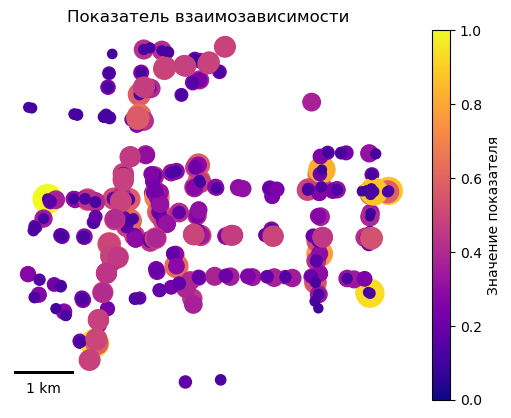

<function __main__.cross_layer_dependence(G_multilayer, all_shortest_paths, output_file)>

In [42]:
#2 Взаимозависимость
def cross_layer_dependence(G_multilayer, all_shortest_paths, output_file):
    """
    Вычисляет, визуализирует и сохраняет показатель взаимозависимости для каждой вершины в графе в CSV файл.

    Параметры:
    - G_multilayer (networkx.Graph): Многослойный граф.
    - all_shortest_paths (dict): Словарь с кратчайшими путями для каждой пары вершин.
    - output_file (str): Путь к выходному файлу.

    Возвращает:
    - cross_layer_dependence (dict): Словарь, содержащий значения показателя взаимозависимости для каждой вершины.
    """
    # Функция вычисления показателя взаимозависимости
    def compute_cross_layer_dependence(G_multilayer, all_shortest_paths):
        cross_layer_dependence = {}
        
        for node in G_multilayer.nodes():
            single_layer_paths = 0
            multiple_layer_paths = 0
            
            for source, target in all_shortest_paths.keys():
                if source != node and target != node:
                    shortest_path = all_shortest_paths[(source, target)]
                    
                    if node in shortest_path:
                        if len(set(G_multilayer.nodes[node]['layer'] for node in shortest_path)) == 2:
                            single_layer_paths += 1
                        else:
                            multiple_layer_paths += 1
            
            cross_layer_dependence[node] = multiple_layer_paths / (single_layer_paths + multiple_layer_paths)
        
        return cross_layer_dependence

    # Функция визуализации показателя взаимозависимости
    def visualize_cross_layer_dependence(G, cross_layer_dependence):
        pos = {node: (G.nodes[node]['utm_x'], G.nodes[node]['utm_y']) for node in G.nodes()}
        node_size = [cross_layer_dependence[node] * 500 for node in G.nodes()]
        node_color = list(cross_layer_dependence.values())
        cmap = plt.cm.plasma
        vmin = min(node_color)
        vmax = max(node_color)
        node_color = [cmap((x - vmin) / (vmax - vmin)) for x in node_color]

        scalebar = ScaleBar(1, location='lower left')
        plt.gca().add_artist(scalebar)

        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title("Показатель взаимозависимости")
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=plt.gca(), label="Значение показателя")
        plt.axis('off')
        plt.show()

    # Функция сохранения показателя взаимозависимости в CSV файл
    def save_cross_layer_dependence_to_csv_with_coordinates(G, cross_layer_dependence, output_file):
        data = []

        for node, dependence in cross_layer_dependence.items():
            layer = G.nodes[node]['layer']
            utm_x = G.nodes[node]['utm_x']
            utm_y = G.nodes[node]['utm_y']
            data.append({'Вершина': node, 'Слой': layer, 'Показатель взаимозависимости': dependence, 'UTM_X': utm_x, 'UTM_Y': utm_y})

        df = pd.DataFrame(data)
        df.to_csv(output_file, index=False)

    # Вычисление показателя взаимозависимости
    comp_cross_layer_dependence = compute_cross_layer_dependence(G_multilayer, all_shortest_paths)

    # Визуализация показателя взаимозависимости
    visualize_cross_layer_dependence(G_multilayer, comp_cross_layer_dependence)

    # Сохранение показателя взаимозависимости в CSV
    save_cross_layer_dependence_to_csv_with_coordinates(G_multilayer, comp_cross_layer_dependence, output_file)

    return cross_layer_dependence
cross_layer_dependence(G_multilayer, all_shortest_paths, 'cross_dependence.csv')

In [43]:
#3 Cross-average distance
def compute_cross_average_distance_for_all_layers(G_multilayer, all_shortest_paths):
    """
    Вычисляет значение Cross-average distance для всех возможных пар слоев в мультислойном графе.

    Параметры:
    - G_multilayer (networkx.Graph): Мультислойный граф.
    - all_shortest_paths (dict): Словарь с кратчайшими путями для каждой пары вершин.

    Возвращает:
    - cross_average_distances (dict): Словарь, содержащий значения Cross-average distance для всех пар слоев.
    """

    def compute_cross_average_distance(layer_1, layer_2):
        """
        Вычисляет Cross-average distance для указанной пары слоев в мультислойном графе.

        Параметры:
        - layer_1 (str): Первый слой.
        - layer_2 (str): Второй слой.

        Возвращает:
        - cross_average_distance (float): Значение Cross-average distance для указанной пары слоев.
        """

        # Список для хранения кросс-расстояний между вершинами разных слоев
        cross_layer_distances = []

        # Проходим по всем вершинам первого слоя
        for node_1 in G_multilayer.nodes():
            if G_multilayer.nodes[node_1]['layer'] == layer_1:
                # Проходим по всем вершинам второго слоя
                for node_2 in G_multilayer.nodes():
                    if G_multilayer.nodes[node_2]['layer'] == layer_2:
                        # Проверяем, есть ли кратчайший путь между вершинами
                        if (node_1, node_2) in all_shortest_paths:
                            # Получаем длину кратчайшего пути
                            shortest_path_length = len(all_shortest_paths[(node_1, node_2)]) - 1  # Вычитаем 1, так как возвращается список вершин, а не рёбра
                            # Добавляем расстояние в список
                            cross_layer_distances.append(shortest_path_length)

        # Вычисляем среднее значение кросс-расстояний
        if cross_layer_distances:
            cross_average_distance = sum(cross_layer_distances) / len(cross_layer_distances)
        else:
            cross_average_distance = 0

        return cross_average_distance

    # Создаем словарь для хранения Cross-average distance для всех пар слоев
    cross_average_distances = {}

    # Получаем список всех слоев в графе
    layers = set(nx.get_node_attributes(G_multilayer, 'layer').values())

    # Вычисляем Cross-average distance для всех пар слоев
    for layer_1 in layers:
        for layer_2 in layers:
            if layer_1 != layer_2 and (layer_2, layer_1) not in cross_average_distances:  # Исключаем повторяющиеся пары слоев
                cross_average_distance = compute_cross_average_distance(layer_1, layer_2)
                cross_average_distances[(layer_1, layer_2)] = cross_average_distance

    return cross_average_distances
cross_average_distances = compute_cross_average_distance_for_all_layers(G_multilayer, all_shortest_paths)

In [44]:
#4 Степени всех вершин (с учетом ребер связи)
def compute_degree(G_multilayer, filename="degrees.csv"):

    """
    Вычисляет агрегированную степень для каждой вершины в многослойном графе и сохраняет результаты в CSV файл.

    Параметры:
    - G_multilayer (networkx.Graph): Многослойный граф.
    - filename (str): Имя файла для сохранения данных. По умолчанию "degrees.csv".

    Возвращает:
    - aggregated_degrees (dict): Словарь, содержащий агрегированные степени для каждой вершины.
    """
    # Создаем словарь для хранения агрегированных степеней
    aggregated_degrees = {}

    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['node', 'degree', 'layer', 'utm_x', 'utm_y']  # Заголовки столбцов
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()

        # Проходим по всем вершинам графа
        for node in G_multilayer.nodes():
            # Считаем количество ребер, инцидентных вершине
            degree = G_multilayer.degree(node)
            # Добавляем информацию о вершине и ее агрегированной степени в словарь
            aggregated_degrees[node] = degree

            # Получаем информацию о вершине (слое, координатах и т.д.)
            layer = G_multilayer.nodes[node]['layer']
            utm_x = G_multilayer.nodes[node]['utm_x']
            utm_y = G_multilayer.nodes[node]['utm_y']
            # Записываем данные о вершине и ее агрегированной степени в CSV файл
            writer.writerow({'node': node, 'degree': degree, 'layer': layer, 'utm_x': utm_x, 'utm_y': utm_y})

    return aggregated_degrees

degrees = compute_degree(G_multilayer)

In [45]:
#5 Степени всех вершин (только ребра родного слоя)
def compute_layer_specific_degrees(G_multilayer, filename="layer_specific_degrees.csv"):
    """
    Вычисляет количество ребер с каждой вершиной для определенного слоя в многослойном графе
    и сохраняет результаты в CSV файл.

    Параметры:
    - G_multilayer (networkx.Graph): Многослойный граф.
    - filename (str): Имя файла для сохранения данных. По умолчанию "layer_specific_degrees.csv".
    """
    # Открываем файл для записи
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['node', 'layer', 'utm_x', 'utm_y', 'edge_count']  # Заголовки столбцов
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Проходим по каждой вершине в графе
        for node in G_multilayer.nodes():
            stop_id, layer = node  # Разделяем идентификатор остановки и слой
            utm_x = G_multilayer.nodes[node]['utm_x']
            utm_y = G_multilayer.nodes[node]['utm_y']
            # Считаем количество ребер с текущей вершиной для определенного слоя
            edge_count = sum(1 for edge in G_multilayer.edges(node) if G_multilayer.edges[edge]['layer'] == layer)
            # Записываем данные о вершине и количестве ребер в CSV файл
            writer.writerow({'node': stop_id, 'layer': layer, 'utm_x': utm_x, 'utm_y': utm_y, 'edge_count': edge_count})
layer_specific_degrees = compute_layer_specific_degrees(G_multilayer)

In [46]:
#6 Агрегированная степень вершин
def compute_aggregated_degree(G_multilayer, filename="aggregated_degrees.csv"):
    """
    Вычисляет агрегированную степень для вершин в многослойном графе, объединяя вершины с одинаковыми stop_id,
    и сохраняет результаты в CSV файл.

    Параметры:
    - G_multilayer (networkx.Graph): Многослойный граф.
    - filename (str): Имя файла для сохранения данных. По умолчанию "aggregated_degrees.csv".
    """
    # Словарь для хранения агрегированных степеней
    aggregated_degrees = {}

    # Проходим по каждой вершине в графе
    for node in G_multilayer.nodes():
        stop_id, layer = node  # Разделяем идентификатор остановки и слой
        utm_x = G_multilayer.nodes[node]['utm_x']
        utm_y = G_multilayer.nodes[node]['utm_y']
        edge_count = sum(1 for edge in G_multilayer.edges(node) if G_multilayer.edges[edge]['layer'] == layer)
        
        # Если уникальный идентификатор (stop_id) уже существует в словаре, то суммируем степени
        if stop_id in aggregated_degrees:
            aggregated_degrees[stop_id]['edge_count'] += edge_count
        else:
            # Создаем новую запись в словаре
            aggregated_degrees[stop_id] = {'utm_x': utm_x, 'utm_y': utm_y, 'edge_count': edge_count}

    # Открываем файл для записи
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['stop_id', 'utm_x', 'utm_y', 'aggregated_degree']  # Заголовки столбцов
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Записываем агрегированные степени в CSV файл
        for stop_id, data in aggregated_degrees.items():
            writer.writerow({'stop_id': stop_id, 'utm_x': data['utm_x'], 'utm_y': data['utm_y'], 'aggregated_degree': data['edge_count']})
aggregated_degree = compute_aggregated_degree(G_multilayer)

In [47]:
#7 Многослойная степень вершин
def compute_stop_id_specific_degrees(G_multilayer):
    """
    Вычисляет количество ребер для каждой уникальной остановки (stop_id) в многослойном графе
    для каждого из трех слоев (0, 3, transfer), а также сохраняет их координаты.

    Параметры:
    - G_multilayer (networkx.Graph): Многослойный граф.

    Возвращает:
    - stop_id_specific_degrees (dict): Словарь, содержащий информацию о количестве ребер для каждой уникальной остановки
      в каждом из трех слоев, а также их координаты utm_x и utm_y.
    """
    # Словарь для хранения степеней для каждой уникальной остановки (stop_id) в каждом из трех слоев
    stop_id_specific_degrees = {}

    # Проходим по каждой вершине в графе
    for node in G_multilayer.nodes():
        stop_id, layer = node  # Разделяем идентификатор остановки и слой
        
        # Получаем координаты utm_x и utm_y только один раз для каждой уникальной остановки
        if stop_id not in stop_id_specific_degrees:
            utm_x = G_multilayer.nodes[node]['utm_x']
            utm_y = G_multilayer.nodes[node]['utm_y']
            stop_id_specific_degrees[stop_id] = {'utm_x': utm_x, 'utm_y': utm_y}

        # Вычисляем количество ребер для текущей вершины в каждом из слоев
        layer_degrees = compute_layer_specific_degrees_2(G_multilayer, stop_id, layer)

        # Записываем информацию о степени в словарь
        stop_id_specific_degrees[stop_id][layer] = layer_degrees

    return stop_id_specific_degrees

def compute_layer_specific_degrees_2(G_multilayer, stop_id, layer):
    """
    Вычисляет количество ребер для определенного слоя (0, 3, transfer) для заданной вершины.

    Параметры:
    - G_multilayer (networkx.Graph): Многослойный граф.
    - stop_id (int): Идентификатор остановки.
    - layer (str): Слой (0, 3, transfer).

    Возвращает:
    - edge_count (int): Количество ребер для заданной вершины и слоя.
    """
    # Считаем количество ребер с текущей вершиной для определенного слоя
    edges = G_multilayer.edges([(stop_id, layer)])
    edge_count = sum(1 for edge in edges if G_multilayer.edges[edge]['layer'] == layer)
    return edge_count

def complete_missing_layers(stop_id_specific_degrees):
    """
    Дополняет словарь stop_id_specific_degrees отсутствующими слоями (0, 3, transfer)
    и устанавливает для них значение edge_count в 0.

    Параметры:
    - stop_id_specific_degrees (dict): Словарь с информацией о количестве ребер для каждой уникальной остановки
      в каждом из трех слоев, а также их координаты utm_x и utm_y.

    Возвращает:
    - updated_stop_id_specific_degrees (dict): Обновленный словарь stop_id_specific_degrees.
    """
    updated_stop_id_specific_degrees = {}

    for stop_id, layer_degrees in stop_id_specific_degrees.items():
        missing_layers = set(['0', '3', 'transfer']) - set(layer_degrees.keys())
        for layer in missing_layers:
            layer_degrees[layer] = 0  # Добавляем отсутствующий слой и устанавливаем количество ребер в 0
        updated_stop_id_specific_degrees[stop_id] = layer_degrees

    return updated_stop_id_specific_degrees

stop_id_specific_degrees = compute_stop_id_specific_degrees(G_multilayer)
updated_stop_id_specific_degrees = complete_missing_layers(stop_id_specific_degrees)

def create_csv_from_stop_id_specific_degrees(stop_id_specific_degrees, filename="multilayer_degrees.csv"):
    """
    Создает CSV файл на основе словаря stop_id_specific_degrees.

    Параметры:
    - stop_id_specific_degrees (dict): Словарь с данными о количестве ребер для каждой уникальной остановки
      в каждом из трех слоев.
    - filename (str): Имя файла для сохранения данных. По умолчанию "multilayer_degrees.csv".
    """
    # Открываем файл для записи
    with open(filename, 'w', newline='') as csvfile:
        fieldnames = ['stop_id', 'utm_x', 'utm_y', 'multilayer_degree']  # Заголовки столбцов
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Записываем данные о количестве ребер для каждой уникальной остановки в каждом из трех слоев
        for stop_id, layer_degrees in stop_id_specific_degrees.items():
            edge_counts = [str(layer_degrees.get(layer, 0)) for layer in ['0', '3', 'transfer']]  # Получаем количество ребер для каждого слоя
            edge_counts_str = "/".join(edge_counts)
            writer.writerow({'stop_id': stop_id, 'utm_x': layer_degrees['utm_x'], 'utm_y': layer_degrees['utm_y'], 'multilayer_degree': edge_counts_str})
create_csv_from_stop_id_specific_degrees(updated_stop_id_specific_degrees)

In [48]:
print(cross_average_distances)

{('3', 'transfer'): 3.025189868384429, ('3', '0'): 4.020749947335159, ('transfer', '0'): 2.9966675211484235}


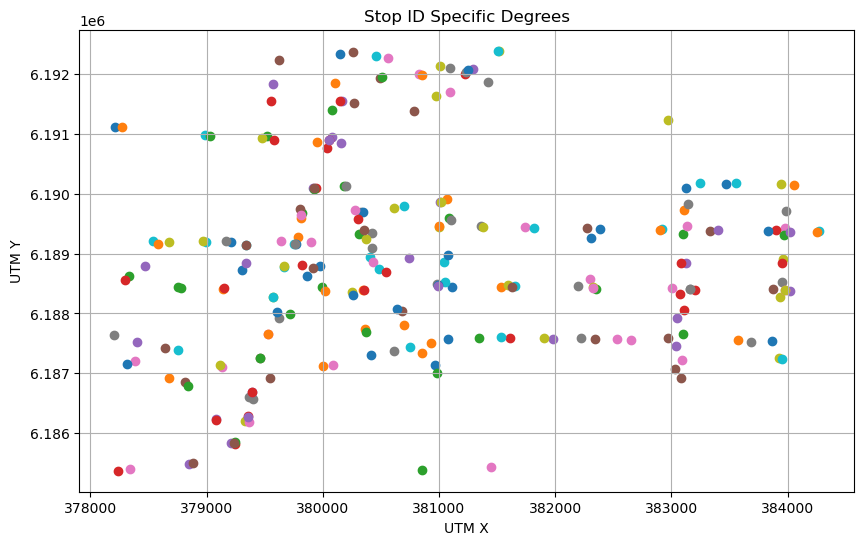

In [49]:
def visualize_stop_id_specific_degrees(stop_id_specific_degrees):
    """
    Visualizes stop_id_specific_degrees data using a scatter plot.

    Parameters:
    - stop_id_specific_degrees (dict): Dictionary containing information about edge counts for each stop_id.
    """
    # Создаем новый график
    plt.figure(figsize=(10, 6))

    # Проходим по каждому stop_id
    for stop_id, data in stop_id_specific_degrees.items():
        utm_x = data['utm_x']
        utm_y = data['utm_y']

        # Наносим точку на график
        plt.scatter(utm_x, utm_y, label=f'Stop ID: {stop_id}')

    # Добавляем подписи к осям и легенду
    plt.xlabel('UTM X')
    plt.ylabel('UTM Y')
    plt.title('Stop ID Specific Degrees')
    
    # Отображаем график
    plt.grid(True)
    plt.show()

# Пример использования
stop_id_specific_degrees = compute_stop_id_specific_degrees(G_multilayer)  # Предполагается, что у вас есть этот словарь

# Вызываем функцию для визуализации данных
visualize_stop_id_specific_degrees(stop_id_specific_degrees)


In [50]:
import pprint

pprint.pprint(updated_stop_id_specific_degrees)

{35360: {'0': 0,
         '3': 4,
         'transfer': 88,
         'utm_x': 381071.64231695107,
         'utm_y': 6189919.859127269},
 35361: {'0': 0,
         '3': 6,
         'transfer': 105,
         'utm_x': 381001.2863828734,
         'utm_y': 6189456.880429185},
 35362: {'0': 0,
         '3': 5,
         'transfer': 113,
         'utm_x': 380373.83193965355,
         'utm_y': 6189244.3104948215},
 35363: {'0': 0,
         '3': 5,
         'transfer': 118,
         'utm_x': 380404.42043099104,
         'utm_y': 6188937.794022845},
 35364: {'0': 0,
         '3': 3,
         'transfer': 118,
         'utm_x': 379863.44512043404,
         'utm_y': 6188631.263031916},
 35365: {'0': 0,
         '3': 3,
         'transfer': 124,
         'utm_x': 380014.7440621151,
         'utm_y': 6188368.170284769},
 35366: {'0': 0,
         '3': 3,
         'transfer': 110,
         'utm_x': 380375.34956888127,
         'utm_y': 6187692.856397912},
 35367: {'0': 0,
         '3': 4,
         'transf

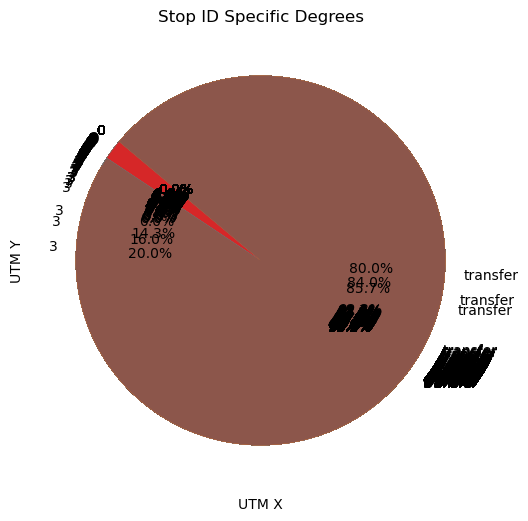

In [51]:
import matplotlib.pyplot as plt

def visualize_stop_id_specific_degrees(stop_id_specific_degrees):
    """
    Visualizes stop_id_specific_degrees data using pie charts.

    Parameters:
    - stop_id_specific_degrees (dict): Dictionary containing information about edge counts for each stop_id.
    """
    # Создаем новый график
    plt.figure(figsize=(10, 6))

    # Проходим по каждому stop_id
    for stop_id, data in stop_id_specific_degrees.items():
        utm_x = data['utm_x']
        utm_y = data['utm_y']
        layers = ['0', '3', 'transfer']
        counts = [data[layer] for layer in layers]

        # Наносим точку на график
        plt.scatter(utm_x, utm_y, s=200, alpha=0.5)
        
        # Размеры круговых диаграмм
        sizes = [count * 100 for count in counts]

        # Отображаем круговую диаграмму
        plt.pie(sizes, labels=layers, autopct='%1.1f%%', startangle=140)

    # Добавляем подписи к осям
    plt.xlabel('UTM X')
    plt.ylabel('UTM Y')
    plt.title('Stop ID Specific Degrees')

    # Отображаем график
    plt.grid(True)
    plt.show()

# Пример использования
visualize_stop_id_specific_degrees(updated_stop_id_specific_degrees)